<a href="https://colab.research.google.com/github/ruus77/-AmericanSignLanguagePredictions/blob/main/AmericanSignLanguagePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"torch: {torch.__version__}, torchvision: {torchvision.__version__}, device: {device}")

torch: 2.5.0+cu121, torchvision: 0.20.0+cu121, device: cuda


In [3]:
from pathlib import Path
data_path = Path(".")

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)

!cp kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kapillondhe/american-sign-language

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kapillondhe/american-sign-language
License(s): GPL-2.0
100% 4.64G/4.64G [03:47<00:00, 20.8MB/s]
100% 4.64G/4.64G [03:47<00:00, 21.8MB/s]


In [5]:
import zipfile
with zipfile.ZipFile('american-sign-language.zip', 'r') as zip_ref:
    zip_ref.extractall('american-sign-language')

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


In [6]:
from pathlib import Path
data_path = Path(".")
image_path = data_path / "american-sign-language"
test_train_path = image_path / "ASL_Dataset"
train_dir = test_train_path / "Train"
test_dir = test_train_path / "Test"
train_dir, test_dir

(PosixPath('american-sign-language/ASL_Dataset/Train'),
 PosixPath('american-sign-language/ASL_Dataset/Test'))

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_transforms = weights.transforms()

In [8]:
effnet_b0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 183MB/s]


In [9]:
from torchvision import transforms, datasets

data_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda img: img.mul(255).byte()),
                                     #transforms.ConvertImageDtype(torch.float),
                                     transforms.RandAugment(magnitude=9,
                                                            num_ops=os.cpu_count()),
                                     model_transforms])

In [10]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)
class_names = train_data.classes
len(train_data), len(test_data), len(class_names)

(165670, 112, 28)

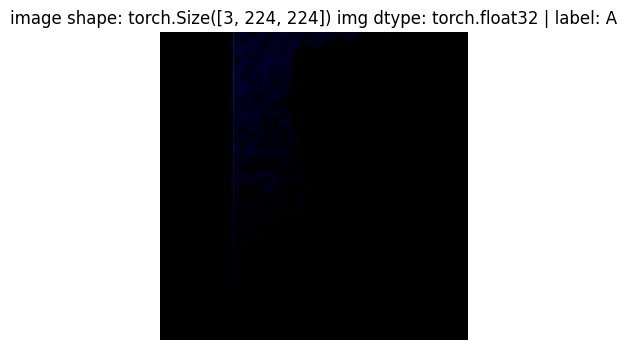

In [11]:
img, label = next(iter(train_data))
plt.figure(figsize=(6, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"image shape: {img.shape} img dtype: {img.dtype} | label: {class_names[label]}")
plt.axis(False);

In [12]:
def seed(seed=95732035):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

## 10%

In [31]:
from torch.utils.data import Subset, DataLoader
seed(52)
train_size = int(0.005 * len(train_data))
test_size = int(0.5 * len(test_data))

indices_train = torch.randperm(len(train_data))[:train_size]
indices_test = torch.randperm(len(test_data))[:test_size]

train_subset10 = Subset(dataset=train_data,
                       indices=indices_train)
test_subset10 = Subset(dataset=test_data,
                       indices=indices_test)

len(train_subset10), len(test_subset10)


(828, 56)

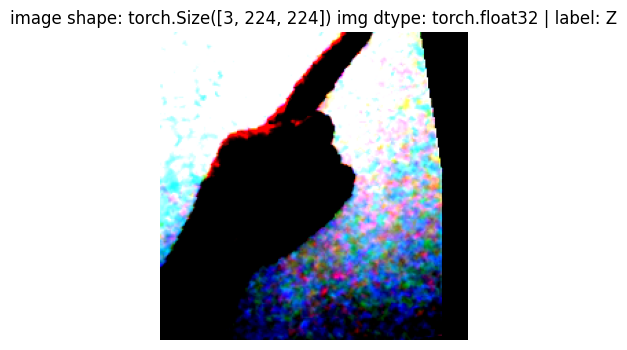

In [32]:
img, label = next(iter(train_subset10))
img.type(torch.uint8)
plt.figure(figsize=(6, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"image shape: {img.shape} img dtype: {img.dtype} | label: {class_names[label]}")
plt.axis(False);

## 20%


In [33]:
from torch.utils.data import Subset, DataLoader
seed(342)
train_size = int(0.1 * len(train_data))
test_size = int(0.8 * len(test_data))

indices_train = torch.randperm(len(train_data))[:train_size]
indices_test = torch.randperm(len(test_data))[:test_size]

train_subset20 = Subset(dataset=train_data,
                       indices=indices_train)
test_subset20 = Subset(dataset=test_data,
                       indices=indices_test)

len(train_subset20), len(test_subset20)

(16567, 89)

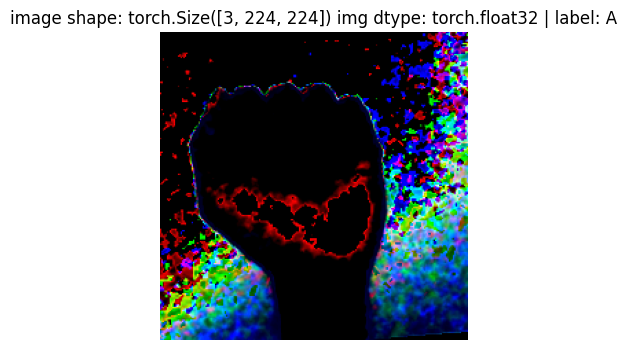

In [34]:
img, label = next(iter(train_subset20))

plt.figure(figsize=(6, 4))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"image shape: {img.shape} img dtype: {img.dtype} | label: {class_names[label]}")
plt.axis(False);

In [35]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader10 = DataLoader(train_subset10,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)

test_dataloader10 = DataLoader(test_subset10,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)


train_dataloader20 = DataLoader(train_subset20,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)

test_dataloader20 = DataLoader(test_subset20,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)



In [36]:
effnet_b0.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=28, bias=True)
)

In [37]:
for params in effnet_b0.features.parameters():
  params.requires_grad = False

In [38]:
from torch import nn
effnet_b0.classifier = nn.Sequential(nn.Dropout(p=0.2,
                                                inplace=True),
                                     nn.Linear(in_features=1280,
                                               out_features=len(class_names),
                                               device=device,
                                               bias=True)).to(device)

In [39]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [40]:
summary(input_size=(32 , 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "trainable", "num_params"],
        col_width=20,
        row_settings=['var_names'],
        model=effnet_b0)

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 28]             Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

In [41]:
optimizer = torch.optim.Adam(params=effnet_b0.parameters(),
                             lr=0.001,
                             weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [42]:
def train_step(model : nn.Module,
               dataloader :torch.utils.data.dataloader,
               optimizer : torch.optim,
               loss_fn: nn.Module,
               device : torch.device = device):
  model.train()
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [43]:
def test_step(model : nn.Module,
              dataloader :torch.utils.data.dataloader,
              loss_fn: nn.Module,
              device : torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [44]:
from typing import Dict, List
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [45]:
seed(4619)
EPOCHS = [5]
dataloaders = {
    "loaders_20": [train_dataloader20, test_dataloader20],
    "loaders_10": [train_dataloader10, test_dataloader10]
}

for epoch in range(len(EPOCHS)):
    for loader_key, loader_values in dataloaders.items():
        train_dataloader, test_dataloader = loader_values
        print(f"[INFO] Number of epochs: {EPOCHS[epoch]}")
        print(f"[INFO] Dataloader set: {loader_key}")
        print("-----------------------------------------")
        results = train(
            model=effnet_b0,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=EPOCHS[epoch],
            device=device
        )

[INFO] Number of epochs: 5
[INFO] Dataloader set: loaders_20
-----------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1878 | train_acc: 0.7837 | test_loss: 0.3465 | test_acc: 0.9346
Epoch: 2 | train_loss: 0.4934 | train_acc: 0.8956 | test_loss: 0.2116 | test_acc: 0.9554
Epoch: 3 | train_loss: 0.3757 | train_acc: 0.9101 | test_loss: 0.1581 | test_acc: 0.9658
Epoch: 4 | train_loss: 0.3320 | train_acc: 0.9149 | test_loss: 0.0656 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.2962 | train_acc: 0.9210 | test_loss: 0.0734 | test_acc: 0.9688
[INFO] Number of epochs: 5
[INFO] Dataloader set: loaders_10
-----------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2705 | train_acc: 0.9226 | test_loss: 0.1377 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.3116 | train_acc: 0.9128 | test_loss: 0.1684 | test_acc: 0.9635
Epoch: 3 | train_loss: 0.3084 | train_acc: 0.9081 | test_loss: 0.0696 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.2750 | train_acc: 0.9299 | test_loss: 0.0649 | test_acc: 0.9844
Epoch: 5 | train_loss: 0.3062 | train_acc: 0.9105 | test_loss: 0.1432 | test_acc: 0.9427


In [46]:
results

{'train_loss': [0.27046003851753014,
  0.31159121772417653,
  0.30837517231702805,
  0.2750341021097623,
  0.30623187439946026],
 'train_acc': [0.9225618131868132,
  0.9127747252747253,
  0.9081387362637362,
  0.9299450549450549,
  0.9105425824175823],
 'test_loss': [0.13773055747151375,
  0.16844509541988373,
  0.06956738978624344,
  0.06488390080630779,
  0.14320069923996925],
 'test_acc': [0.9791666666666667,
  0.9635416666666667,
  1.0,
  0.984375,
  0.9427083333333333]}

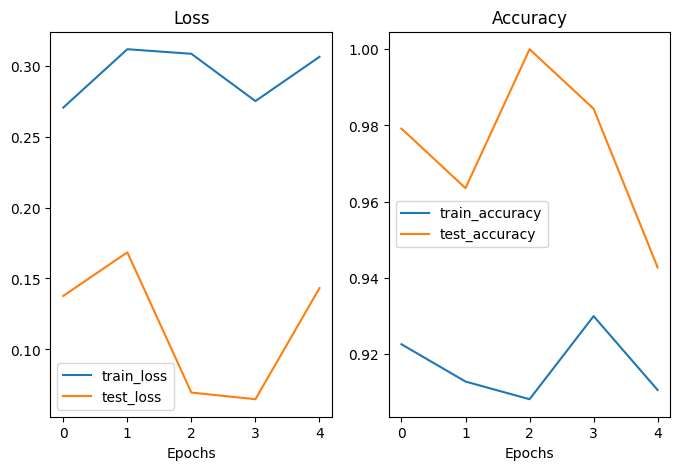

In [47]:
def plot_loss_acc(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(8, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_acc(results)

In [48]:
from torch.utils.data import Subset, DataLoader
seed(342)
train_size = int(0.005 * len(train_data))
test_size = int(1 * len(test_data))

indices_train = torch.randperm(len(train_data))[:train_size]
indices_test = torch.randperm(len(test_data))[:test_size]

train_subset5 = Subset(dataset=train_data,
                       indices=indices_train)
test_subset100 = Subset(dataset=test_data,
                       indices=indices_test)

len(train_subset5), len(test_subset100)

(828, 112)

In [49]:
train_dataloader5 = DataLoader(train_subset5,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)

test_dataloader100 = DataLoader(test_subset100,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=True)



In [50]:
seed(5154619)
print("-----------------------------------------")
results = train(
  model=effnet_b0,
  train_dataloader=train_dataloader5,
  test_dataloader=test_dataloader100,
  optimizer=optimizer,
  loss_fn=loss_fn,
  epochs=10,
  device=device)

-----------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2889 | train_acc: 0.9251 | test_loss: 0.1677 | test_acc: 0.9609
Epoch: 2 | train_loss: 0.2764 | train_acc: 0.9279 | test_loss: 0.1534 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.2918 | train_acc: 0.9214 | test_loss: 0.1210 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.2669 | train_acc: 0.9267 | test_loss: 0.0781 | test_acc: 0.9844
Epoch: 5 | train_loss: 0.2908 | train_acc: 0.9217 | test_loss: 0.1272 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.3143 | train_acc: 0.9069 | test_loss: 0.1153 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.2928 | train_acc: 0.9167 | test_loss: 0.1033 | test_acc: 0.9844
Epoch: 8 | train_loss: 0.2855 | train_acc: 0.9284 | test_loss: 0.0987 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.2963 | train_acc: 0.9270 | test_loss: 0.0895 | test_acc: 0.9844
Epoch: 10 | train_loss: 0.2490 | train_acc: 0.9277 | test_loss: 0.1127 | test_acc: 0.9688


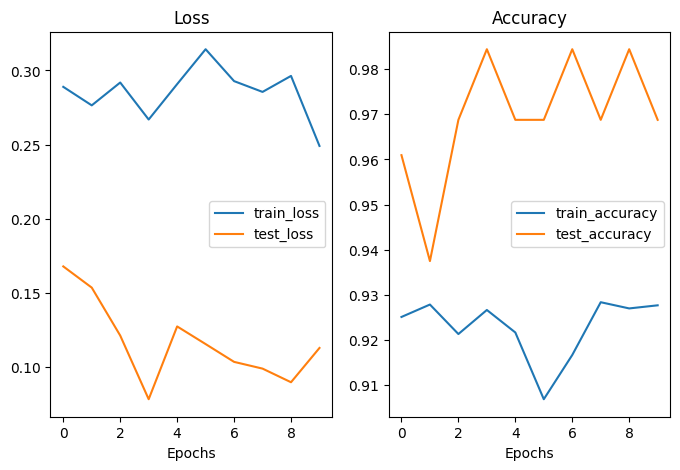

In [51]:
plot_loss_acc(results)

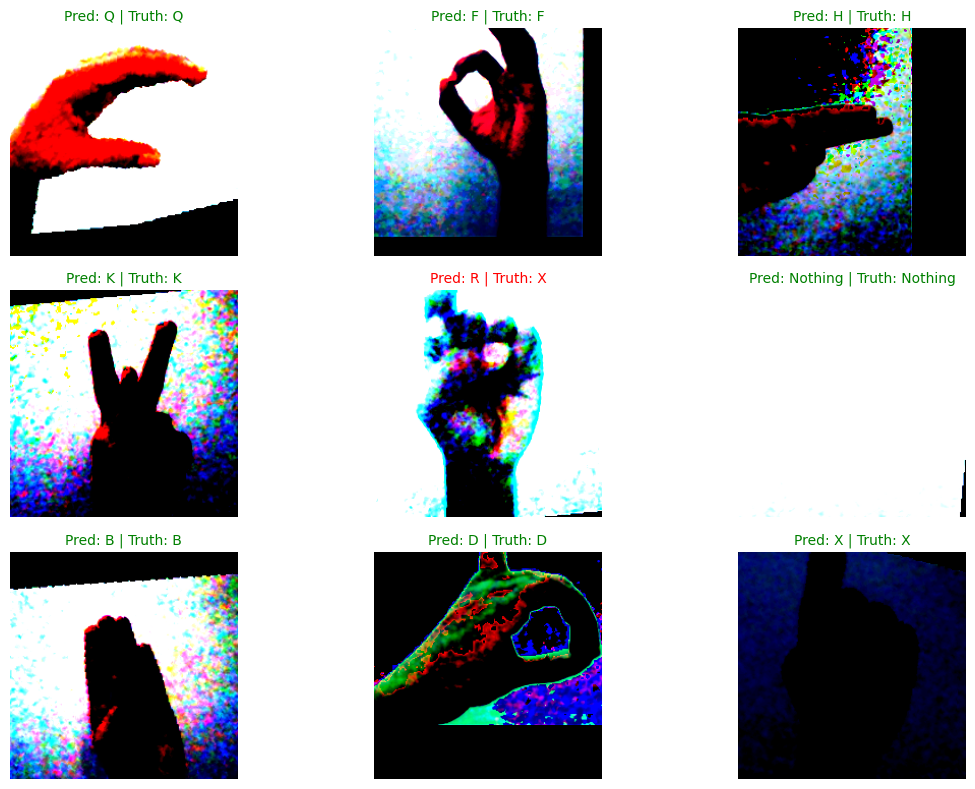

In [52]:
import torch
import matplotlib.pyplot as plt

def plot_and_eval(test_dataloader, model, device):
    seed(85124)
    model.to(device)
    all_preds = []
    all_labels = []
    num_images = 9

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            y_pred_labels = y_pred_logits.argmax(dim=1)

            all_preds.extend(y_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            if len(all_preds) >= num_images:
              break

    plt.figure(figsize=(12, 8))
    images_shown = 0
    for i, (X, y, pred, truth) in enumerate(zip(X, y, all_preds, all_labels)):
        if images_shown >= num_images:
            break

        img = X.cpu()
        if img.dim() == 3:
            img = img.permute(1, 2, 0)

        plt.subplot(3, 3, images_shown + 1)
        plt.imshow(img)

        pred_label = class_names[pred]
        truth_label = class_names[truth]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        color = "g" if pred_label == truth_label else "r"
        plt.title(title_text, fontsize=10, color=color)
        plt.axis("off")

        images_shown += 1
    plt.tight_layout()
    plt.show()

plot_and_eval(test_dataloader=test_dataloader, model=effnet_b0, device=device)

In [53]:
torch.save(effnet_b0.state_dict(), 'effnet_b0.pth')
print(f"Model saved as: effnet_b0.pth")

Model saved as: effnet_b0.pth


In [82]:
import requests
img = data_path / "V.jpeg"

if not img.is_file():
  with open(img, "wb") as f:
    request = requests.get("https://github.com/ruus77/-AmericanSignLanguagePredictions/raw/main/test_1_%22V%22.jpg")
    print(f"Downloading")
    f.write(request.content)

else:
  print(f"{img} already exisits")
img

Downloading


PosixPath('V.jpeg')

In [71]:
img_2 = data_path / "A.jpeg"

if not img_2.is_file():
  with open(img_2, "wb") as f:
    request = requests.get("https://github.com/ruus77/-AmericanSignLanguagePredictions/raw/main/test2_%22A%22.jpg")
    print(f"Downloading")
    f.write(request.content)

else:
  print(f"{img_2} already exisits")
img_2

A.jpeg already exisits


PosixPath('A.jpeg')

In [72]:
from typing import Tuple
from PIL import Image
def custom_image(model: nn.Module,
                 device: torch.device,
                 transforms: torchvision.transforms,
                 image_path: str,
                 image_size: Tuple[int, int]):
  img = Image.open(image_path)

  model.to(device)
  with torch.inference_mode():
    transformed_img = transforms(img).unsqueeze(0).to(device)

    y_pred_logits = model(transformed_img)
    y_pred_labels = torch.softmax(y_pred_logits, dim=1)
    target_image_pred_label = torch.argmax(y_pred_labels, dim=1)

  plt.figure(figsize=(6, 4))
  plt.imshow(img)
  plt.axis(False)
  plt.title(f"Label of image:")
  plt.title(f"Image prediction: {class_names[target_image_pred_label]} | Prob: {y_pred_labels.max():.3f}");


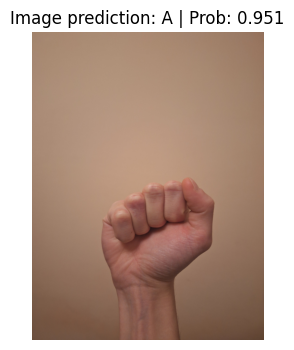

In [60]:
custom_image(model=effnet_b0,
             device=device,
             transforms=data_transform,
             image_path=img_2,
             image_size=(224, 224))